In [345]:
from src.prepare import telco_model_prep
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifierCV
from sklearn.linear_model import SGDClassifier

import eli5

## Prredicting Telco Churn
#### 1. Preprocessing
#### 2. Modeling

In [421]:
telco_df = telco_model_prep()

In [365]:
telco_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   SeniorCitizen                          7043 non-null   int64  
 1   tenure                                 7043 non-null   int64  
 2   MonthlyCharges                         7043 non-null   float64
 3   TotalCharges                           7043 non-null   float64
 4   gender_Male                            7043 non-null   uint8  
 5   Partner_Yes                            7043 non-null   uint8  
 6   Dependents_Yes                         7043 non-null   uint8  
 7   PhoneService_Yes                       7043 non-null   uint8  
 8   MultipleLines_Yes                      7043 non-null   uint8  
 9   InternetService_Fiber_optic            7043 non-null   uint8  
 10  InternetService_No                     7043 non-null   uint8  
 11  Onli

In [366]:
telco_df.head(1)

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_Fiber_optic,...,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Contract_One_year,Contract_Two_year,PaperlessBilling_Yes,PaymentMethod_Credit_card_(automatic),PaymentMethod_Electronic_check,PaymentMethod_Mailed_check,Churn_Yes
0,0,1,29.85,29.85,0,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0


## Preprocessing

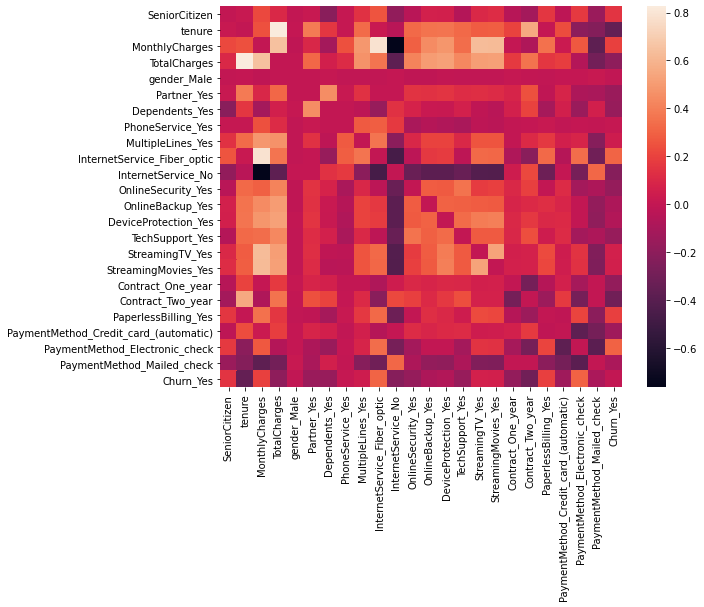

In [368]:
plt.figure(figsize=(9,7))
corr_mat = telco_df.corr()
np.fill_diagonal(corr_mat.values, 0) #we don't care about self-corralation
sns.heatmap(corr_mat);

In [422]:
#isolate the response variable before checking multicollinearity
churn = telco_df.pop("Churn_Yes")

Multicollinearity can be detected via various methods. The most common one – VIF (Variable Inflation Factors).

    ” VIF determines the strength of the correlation between the independent variables. It is predicted by taking a variable and regressing it against every other variable. “

    or

    VIF score of an independent variable represents how well the variable is explained by other independent variables.

* VIF starts at 1 and has no upper limit
* VIF = 1, no correlation between the independent variable and the other variables
* VIF exceeding 5 or 10 indicates high multicollinearity between this independent variable and the others


In [423]:
def calc_vif(X):
    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return(vif)

In [424]:
calc_vif(telco_df)

,variables,VIF
0,SeniorCitizen,1.376314
1,tenure,20.269199
2,MonthlyCharges,211.904464
3,TotalCharges,21.302386
4,gender_Male,2.021551
5,Partner_Yes,2.827182
6,Dependents_Yes,1.976499
7,PhoneService_Yes,47.129037
8,MultipleLines_Yes,2.858522
9,InternetService_Fiber_optic,17.669717


In [425]:
telco_df = telco_df.drop(['MonthlyCharges', 'StreamingTV_Yes', 'PhoneService_Yes',
                          'TotalCharges', 'InternetService_No'], axis=1)

In [426]:
calc_vif(telco_df)

,variables,VIF
0,SeniorCitizen,1.355652
1,tenure,4.697745
2,gender_Male,1.930462
3,Partner_Yes,2.817231
4,Dependents_Yes,1.944708
5,PhoneService_Yes,6.900317
6,MultipleLines_Yes,2.397733
7,InternetService_Fiber_optic,2.970689
8,OnlineSecurity_Yes,1.764206
9,OnlineBackup_Yes,1.983876


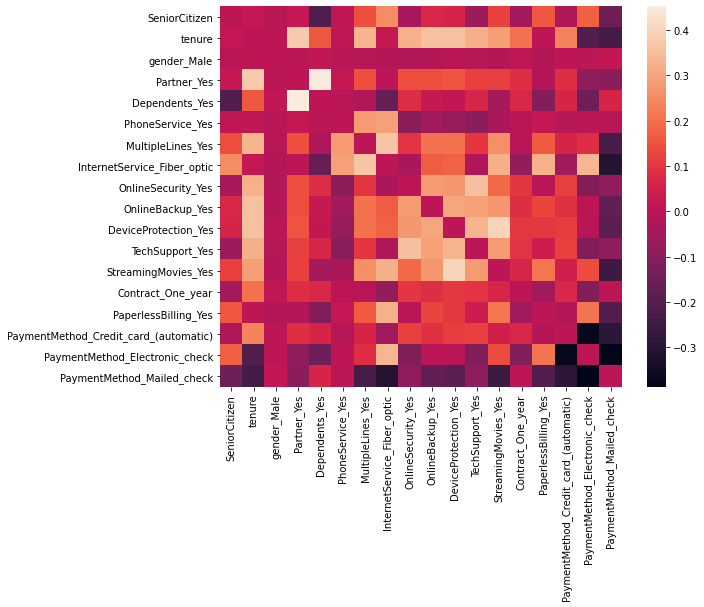

In [427]:
plt.figure(figsize=(9,7))
corr_mat = telco_df.corr()
np.fill_diagonal(corr_mat.values, 0) #we don't care about self-corralation
sns.heatmap(corr_mat);

### Train-Val-Test Split (70%-15%-15%)

In [428]:
X_train, X_test, y_train, y_test = train_test_split(telco_df, churn, test_size=15/100,
                                                    random_state=36, stratify=churn)
#divide X_train and y_train into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=15/85,
                                                    random_state=36, stratify=y_train)

In [429]:
X_train.shape, X_test.shape, X_val.shape, y_test.shape, y_train.shape, y_val.shape

((4929, 18), (1057, 18), (1057, 18), (1057,), (4929,), (1057,))

## Modeling

### Non-linear classifiers

In [418]:
#ccp_alpha prunes weak links based on impurity
#a useless, 100% impure node splits evenly (50/50) whereas a 100% pure node classifies all samples to one class
#capping min_samples_leaf and max_depth prevents overfitting
dt = DecisionTreeClassifier(min_samples_leaf=5, max_depth=10, ccp_alpha=.01, random_state=36).fit(X_train, y_train)
f"Decision tree accuracy: {dt.score(X_val, y_val)}"

'Decision tree accuracy: 0.7984862819299905'

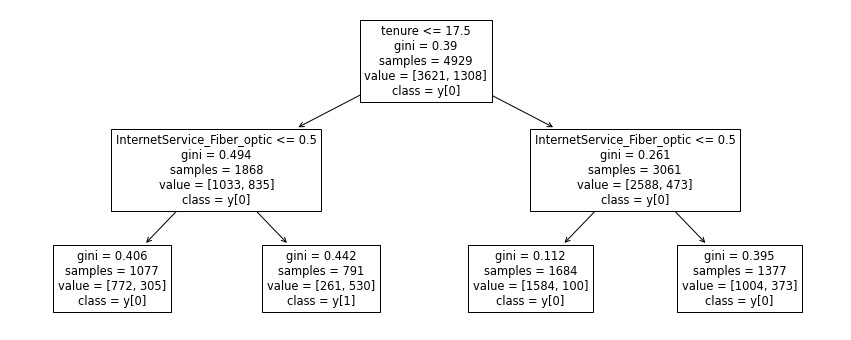

In [403]:
plt.figure(figsize=(15,6))
plot_tree(dt, feature_names=X_val.columns, class_names=True);

In [404]:
rf = RandomForestClassifier(random_state=36).fit(X_train, y_train)
f"Tuned random forest accuracy: {rf.score(X_val, y_val)}"

'Tuned random forest accuracy: 0.7795648060548723'

In [290]:
param_grid = {'n_estimators': [100, 200, 500], #default 100 trees
               'max_depth': [5, 10, 20], #default is ALL THE WAY
               'min_samples_split': [2, 5, 10], #default 2
               'min_samples_leaf': [1, 2, 4]} #default 1
#randomly choose 27 out of 3*3*3*3 (81) possible models 
rf_random = RandomizedSearchCV(estimator=RandomForestClassifier(),
                               param_distributions=param_grid,
                               n_iter=27, cv=3, verbose=0,
                               random_state=36, n_jobs=-1) ##-1 means use all the processors
rf_random.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=27,
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 20],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 500]},
                   random_state=36)

In [320]:
params = rf_random.best_params_
params

{'n_estimators': 500,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_depth': 10}

In [430]:
rf = RandomForestClassifier(**params, random_state=36).fit(X_train, y_train)
f"Tuned random forest accuracy: {rf.score(X_val, y_val)}"

'Tuned random forest accuracy: 0.7975402081362346'

In [431]:
#ranked importance based on Gini index
eli5.show_weights(rf, feature_names=list(X_val.columns))

Weight,Feature
0.3398 ± 0.1329,tenure
0.1511 ± 0.1107,InternetService_Fiber_optic
0.1092 ± 0.1436,PaymentMethod_Electronic_check
0.0432 ± 0.0481,Contract_One_year
0.0427 ± 0.0483,PaperlessBilling_Yes
0.0381 ± 0.0420,OnlineSecurity_Yes
0.0377 ± 0.0418,TechSupport_Yes
0.0275 ± 0.0219,StreamingMovies_Yes
0.0267 ± 0.0266,Partner_Yes
0.0258 ± 0.0208,MultipleLines_Yes


In [432]:
#k=8 was best paramater
knn = KNeighborsClassifier(n_neighbors=8, weights='uniform').fit(X_train, y_train)
f"kNN accuracy: {knn.score(X_val, y_val)}"

'kNN accuracy: 0.7729422894985809'

### Linear classifiers

In [433]:
#linear models will not converge without scaling
lr = make_pipeline(StandardScaler(),LogisticRegression(random_state=36))
lr.fit(X_train, y_train)
f"Logistic regression accuracy: {lr.score(X_val, y_val)}"

'Logistic regression accuracy: 0.8051087984862819'

In [434]:
eli5.show_weights(lr, feature_names=list(X_val.columns))

Weight?,Feature
+0.586,InternetService_Fiber_optic
+0.199,PaymentMethod_Electronic_check
+0.198,PaperlessBilling_Yes
+0.193,MultipleLines_Yes
+0.177,StreamingMovies_Yes
+0.076,SeniorCitizen
+0.017,OnlineBackup_Yes
+0.009,gender_Male
+0.005,DeviceProtection_Yes
-0.021,PaymentMethod_Credit_card_(automatic)


In [447]:
pd.DataFrame(X_train.columns)

,0
0,SeniorCitizen
1,tenure
2,gender_Male
3,Partner_Yes
4,Dependents_Yes
5,PhoneService_Yes
6,MultipleLines_Yes
7,InternetService_Fiber_optic
8,OnlineSecurity_Yes
9,OnlineBackup_Yes


In [453]:
small_train, small_val = X_train.iloc[:,[1,7]], X_val.iloc[:,[1,7]]
#skip scaling
lr2 = LogisticRegression(random_state=36)
lr2.fit(small, y_train)
f"Logistic regression accuracy: {lr2.score(small_val, y_val)}"

'Logistic regression accuracy: 0.7956480605487228'

In [454]:
eli5.show_weights(lr2, feature_names=list(small_val.columns))

Weight?,Feature
+1.724,InternetService_Fiber_optic
-0.043,tenure
-0.741,<BIAS>


\\[ probability = -.741 + fiberoptic*1.72 - tenure*.043  \\]

In [435]:
sgd = make_pipeline(StandardScaler(),
                    SGDClassifier(max_iter=1000, tol=1e-5, random_state=36)).fit(X_train, y_train)
f"Stochastic gradient descent accuracy: {sgd.score(X_val, y_val)}"

'Stochastic gradient descent accuracy: 0.7701040681173131'

In [436]:
rr = make_pipeline(StandardScaler(),
                   RidgeClassifierCV(alphas=[1e-3, 1e-2, 1e-1, 1], cv=3)).fit(X_train, y_train)
f"Ridge regression accuracy: {rr.score(X_val, y_val)}"

'Ridge regression accuracy: 0.8022705771050141'